# SHAP

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import xgboost
import shap
import pandas as pd
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score
shap.initjs()
print(mpl.__version__)

3.5.2


# Example: NHANES I

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html?highlight=shap_interaction_values#SHAP-Interaction-Value-Summary-Plot

In [2]:
# X, y = shap.datasets.nhanesi()
# X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

# xgb_full = xgboost.DMatrix(X, label=y)

# # create a train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# xgb_train = xgboost.DMatrix(X_train, label=y_train)
# xgb_test = xgboost.DMatrix(X_test, label=y_test)

# Adult Census Income

### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.


### Attribute Information:

**Listing of attributes:**

target: >50K, <=50K.

inputs:
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [2]:
# https://archive.ics.uci.edu/ml/datasets/adult

seed = 7
X_display, y_display = shap.datasets.adult(display=True)
X, y = shap.datasets.adult(display=False)
# Fixing some types
y = y.astype(np.uint8)
y_display = y_display.astype(np.uint8)

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    'eta': 0.02,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'seed': seed
}
model = xgboost.train(params, xgb_train, 5000, evals=[(xgb_test, "test")], verbose_eval=1000)

[0]	test-logloss:0.68230
[1000]	test-logloss:0.28195
[2000]	test-logloss:0.27875
[3000]	test-logloss:0.27846
[4000]	test-logloss:0.27930
[4999]	test-logloss:0.28015


In [3]:
y_pred = (model.predict(xgb_test) >= 0.5).astype(np.uint8)
print(f'# of train data: {xgb_train.num_row()}')
print(f'# of train data: {xgb_test.num_row()}')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=y_pred))

# of train data: 26048
# of train data: 6513
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4951
           1       0.78      0.66      0.71      1562

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



In [4]:
idx = np.arange(len(y_test))
sample_idx = np.concatenate((idx[y_test == 0][:5], idx[y_test == 1][:5]))

In [5]:
explainer = shap.TreeExplainer(model, data=X_test)
shap_values = explainer.shap_values(X_test.iloc[sample_idx, :])

In [6]:
i = sample_idx[0]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

In [7]:
i = sample_idx[6]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

calculate all shap values + shape interaction values

In [8]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=uint8), array([4951, 1562], dtype=int64))


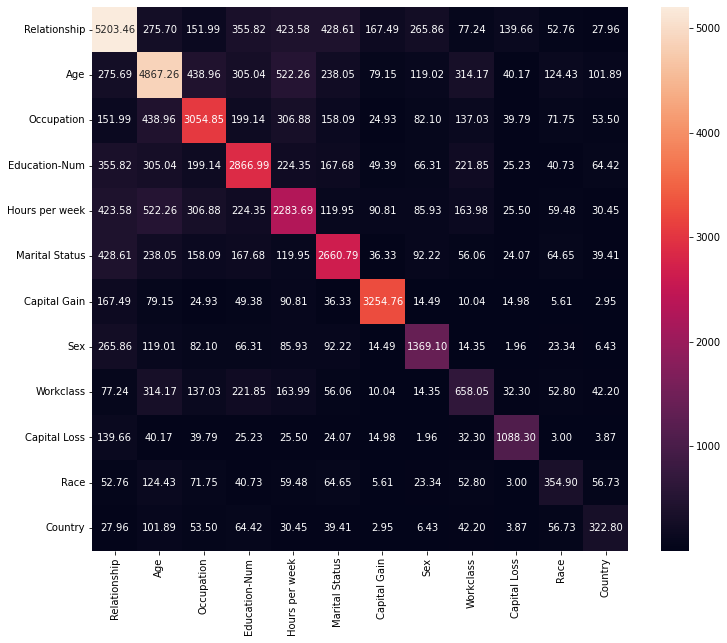

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()
# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).sum(0)
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
sns.heatmap(data=pd.DataFrame(tmp2, index=X_test.columns[inds], columns=X_test.columns[inds]), annot=True, fmt='.2f', ax=ax)
plt.show()

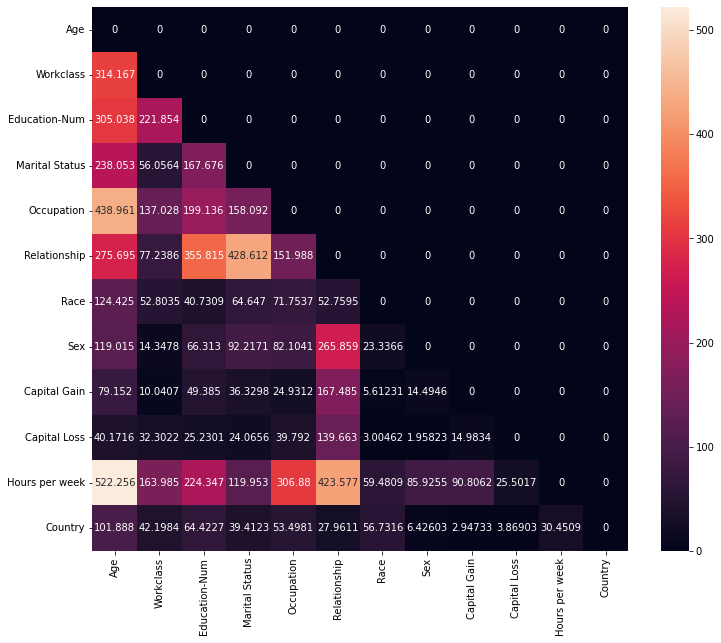

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()

for i in range(len(siv)):
    r, c = np.triu_indices(12)
    siv[i, r, c] = 0.0

# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).sum(0)
sns.heatmap(data=pd.DataFrame(tmp, index=X_test.columns, columns=X_test.columns), annot=True, fmt='g', ax=ax)
plt.show()

In [25]:
def batch_tril_indexing(A, dim=1, cols=None):
    rt_pd = False if cols is None else True
    k = A.shape[dim]
    r, c = np.tril_indices(k, -1)
    if rt_pd:
        cs = list(zip(*(cols[r], cols[c])))
        return pd.DataFrame(A[:, r, c], columns=cs)
    else:
        return A[:, r, c]

In [26]:
shap_values.shape

(6513, 12)

In [28]:
siv_dense = batch_tril_indexing(siv, dim=1, cols=X_test.columns)
siv_dense

,"(Workclass, Age)","(Education-Num, Age)","(Education-Num, Workclass)","(Marital Status, Age)","(Marital Status, Workclass)","(Marital Status, Education-Num)","(Occupation, Age)","(Occupation, Workclass)","(Occupation, Education-Num)","(Occupation, Marital Status)",...,"(Country, Workclass)","(Country, Education-Num)","(Country, Marital Status)","(Country, Occupation)","(Country, Relationship)","(Country, Race)","(Country, Sex)","(Country, Capital Gain)","(Country, Capital Loss)","(Country, Hours per week)"
0,0.025938,0.002009,-0.007029,-0.157218,-0.007111,-0.026619,-0.033413,0.028619,-0.025211,0.025257,...,0.001598,-0.006362,-0.005914,-0.001272,0.000727,-0.003016,0.000285,1.231581e-05,-0.000256,-0.001076
1,0.066085,0.017810,-0.096962,0.003640,0.027792,0.042617,0.028602,-0.012726,0.057507,0.021697,...,-0.012506,0.001740,-0.004805,-0.000709,0.002350,-0.002672,-0.000275,1.251698e-05,0.000149,0.006417
2,-0.038652,0.020911,-0.007085,0.001821,0.002129,0.003630,0.468868,-0.006445,0.005128,-0.003581,...,0.001794,-0.007187,-0.000300,-0.001857,-0.000125,-0.004105,0.000378,-4.893541e-05,0.000135,0.002626
3,0.327300,0.405183,0.330101,-0.014333,0.015391,0.001086,-0.041491,-0.031653,-0.008460,-0.017522,...,0.001315,-0.000107,0.005741,-0.001306,-0.002906,-0.003105,-0.000090,-3.718585e-05,0.000130,-0.001930
4,-0.111667,-0.006674,-0.047047,-0.013631,-0.008854,-0.004565,-0.065434,0.062508,0.053198,-0.005327,...,-0.000520,0.001794,-0.000188,-0.002810,-0.000306,-0.005096,0.000417,4.842877e-06,0.000141,-0.000656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-0.023527,-0.007523,-0.007433,-0.013651,-0.007097,-0.019402,-0.156947,-0.005977,-0.004788,-0.057850,...,0.001663,-0.006353,0.004230,0.002491,-0.001937,-0.002867,-0.000690,-5.151331e-05,0.000131,0.000471
6509,0.086452,0.030258,0.005841,0.052435,0.000026,0.009811,-0.239693,0.070256,-0.012497,-0.007245,...,-0.079842,0.090484,0.021301,-0.073220,0.007255,0.041897,0.007526,1.801178e-04,-0.005625,-0.200258
6510,-0.363184,-0.033498,0.072293,-0.022807,-0.031756,-0.020119,-0.249718,-0.018094,-0.008711,-0.053203,...,-0.009713,-0.005006,0.004044,-0.000269,-0.001410,-0.002720,0.000064,-5.099177e-05,0.000127,0.004457
6511,-0.069788,0.610605,-0.085657,0.043236,-0.011656,0.288547,0.045090,-0.001929,0.068129,-0.011853,...,-0.018759,0.065629,-0.107625,0.025109,0.022678,-0.068487,-0.001199,2.533495e-04,-0.001069,-0.013381
